# Atlas-based electrode regions

It is often useful to group electrodes together based on their spatial location. One way to label an electrode's location is by using an existing brain atlas. There are many existing atlases based on different methodologies. The `nilearn` library allows us to download some [common atlases](https://nilearn.github.io/dev/modules/datasets.html#atlases). This tutorial will show you how to take electrode locations and retrieve labels from an atlas. Then, we will plot electrodes in each region separately.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hassonlab/podcast-ecog-tutorials/blob/main/notebooks/05-atlases.ipynb)

In [33]:
import mne
import numpy as np
import matplotlib.pyplot as plt

from mne_bids import BIDSPath
from nilearn import datasets, image
from collections import Counter
from nilearn.plotting import plot_markers
from scipy.spatial import KDTree

A brain atlas is usually defined with two components. First, a brain map defined as a 2D or 3D array with integers representing the index of the labels that corresponds to the position in the brain map. Then, a mapping from integer indices to string labels is supplied usually as a list. The index "0" is usually used for background, or areas without a label (e.g., outside the brain). The atlas we will use in this tutorial is from Destrieux et al., 2009.

Below we load the atlas then extract the brain map and set up a mapping from index to labels. Notice that the brain map has a 3-dimensional shape. Think of this as a 3D rectangle with the brain inside. A particular 3D coordinate in this space identifies a 3D pixel, known as a voxel, that is cubic millimeter in area. Indexing into this map gives us a number from 0 to the total number of labels available, which will vary from atlas to atlas.

In [12]:
atlas = datasets.fetch_atlas_destrieux_2009()

# Load brain map
atlas_map_filename = atlas['maps']
atlas_map = image.load_img(atlas_map_filename)
atlas_map = atlas_map.get_fdata()
print(f"The brain atlas map has a shape of: {atlas_map.shape}")

# Set up a mapping from index -> label
indices = atlas['labels'].index
names = atlas['labels'].name
atlas_labels = {idx: name for idx, name in zip(indices, names)}

print(f"The atlas has {len(names)} labels.")
print("The first three labels are:")
for i in range(3):
    print(f"Index {i} has label: {atlas_labels[i]}")

The brain atlas map has a shape of: (76, 93, 76)
The atlas has 151 labels.
The first three labels are:
Index 0 has label: Background
Index 1 has label: L G_and_S_frontomargin
Index 2 has label: L G_and_S_occipital_inf


Now we need to get our subject's electrode coordinates so we can look them up within the atlas. We get the `raw` object and extract the coordinates from it, just as before.

In [16]:
edf_path = BIDSPath(root="../../monkey/derivatives/ecogprep",
                    subject="03", datatype="ieeg", description="highgamma", extension=".fif")
edf_paths = edf_path.match()

raw = mne.io.read_raw_fif(edf_paths[0], verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

Coordinate matrix shape:  (235, 3)


Now let's look at just one electrode. We will get its x, y, and z coordinates and look them up within the atlas map. This gives us back a label index which we can use to retrieve the atlas label.

In [24]:
electrode_coordinate = coords[0]
x, y, z = electrode_coordinate.astype(int)
label_index = atlas_map[x, y, z]
label = atlas_labels[label_index]

print("Electrode x,y,z coordinates:", electrode_coordinate)
print("Map index:", label_index)
print("Atlas label:", label)

Electrode x,y,z coordinates: [-54.0000014   39.99999911  23.00000004]
Map index: 62.0
Atlas label: L S_oc-temp_med_and_Lingual


The function below encapsulates this functionality and makes it efficient to run for all electrodes.

In [26]:
def get_coord_atlas_labels(
    coords: np.array, atlas_map: str, atlas_labels: list[str]
) -> list[str]:
    atlas_map = image.load_img(atlas_map)
    atlas_image = atlas_map.get_fdata().astype(int)

    # find non-zero labels
    image_label_coords = np.nonzero(atlas_image)

    # transform label indices to MNI space
    atlas_coords = np.vstack(
        image.coord_transform(*image_label_coords, atlas_map.affine)
    ).T

    tree = KDTree(atlas_coords)
    _, nearest_neighbor = tree.query(coords, k=1)

    # look up neighbor index in map
    x = image_label_coords[0][nearest_neighbor]
    y = image_label_coords[1][nearest_neighbor]
    z = image_label_coords[2][nearest_neighbor]

    # convert map index to label
    elec_label_ids = atlas_image[x, y, z]
    elec_labels = [atlas_labels[i] for i in elec_label_ids]

    return elec_labels

And run it for all the electrodes:

In [31]:
original_elec_labels = get_coord_atlas_labels(coords, atlas['maps'], atlas_labels)
# strip the hemisphere tag from the labels to group left and right hemispheres together
elec_labels = [label.split()[1] for label in original_elec_labels]

print(f"There are {len(elec_labels)} electrodes.")
print("The first five labels are:")
for i in range(5):
    print(f"Electrode name '{raw.ch_names[i]}' has label: {elec_labels[i]}")

There are 235 electrodes.
The first five labels are:
Electrode name 'LGA2' has label: G_front_middle
Electrode name 'LGA3' has label: G_front_middle
Electrode name 'LGA4' has label: G_front_middle
Electrode name 'LGA5' has label: G_precentral
Electrode name 'LGA6' has label: G_precentral


Let's summarize how many electrodes are within each label—also known as region of interest (ROI).

In [32]:
counter = Counter(elec_labels)
top_rois = counter.most_common(6)
top_rois

[('G_temp_sup-Lateral', 29),
 ('G_front_inf-Triangul', 26),
 ('G_temporal_middle', 23),
 ('Pole_temporal', 14),
 ('G_front_middle', 13),
 ('G_front_inf-Opercular', 13)]

And then plot the electrodes within each ROI:

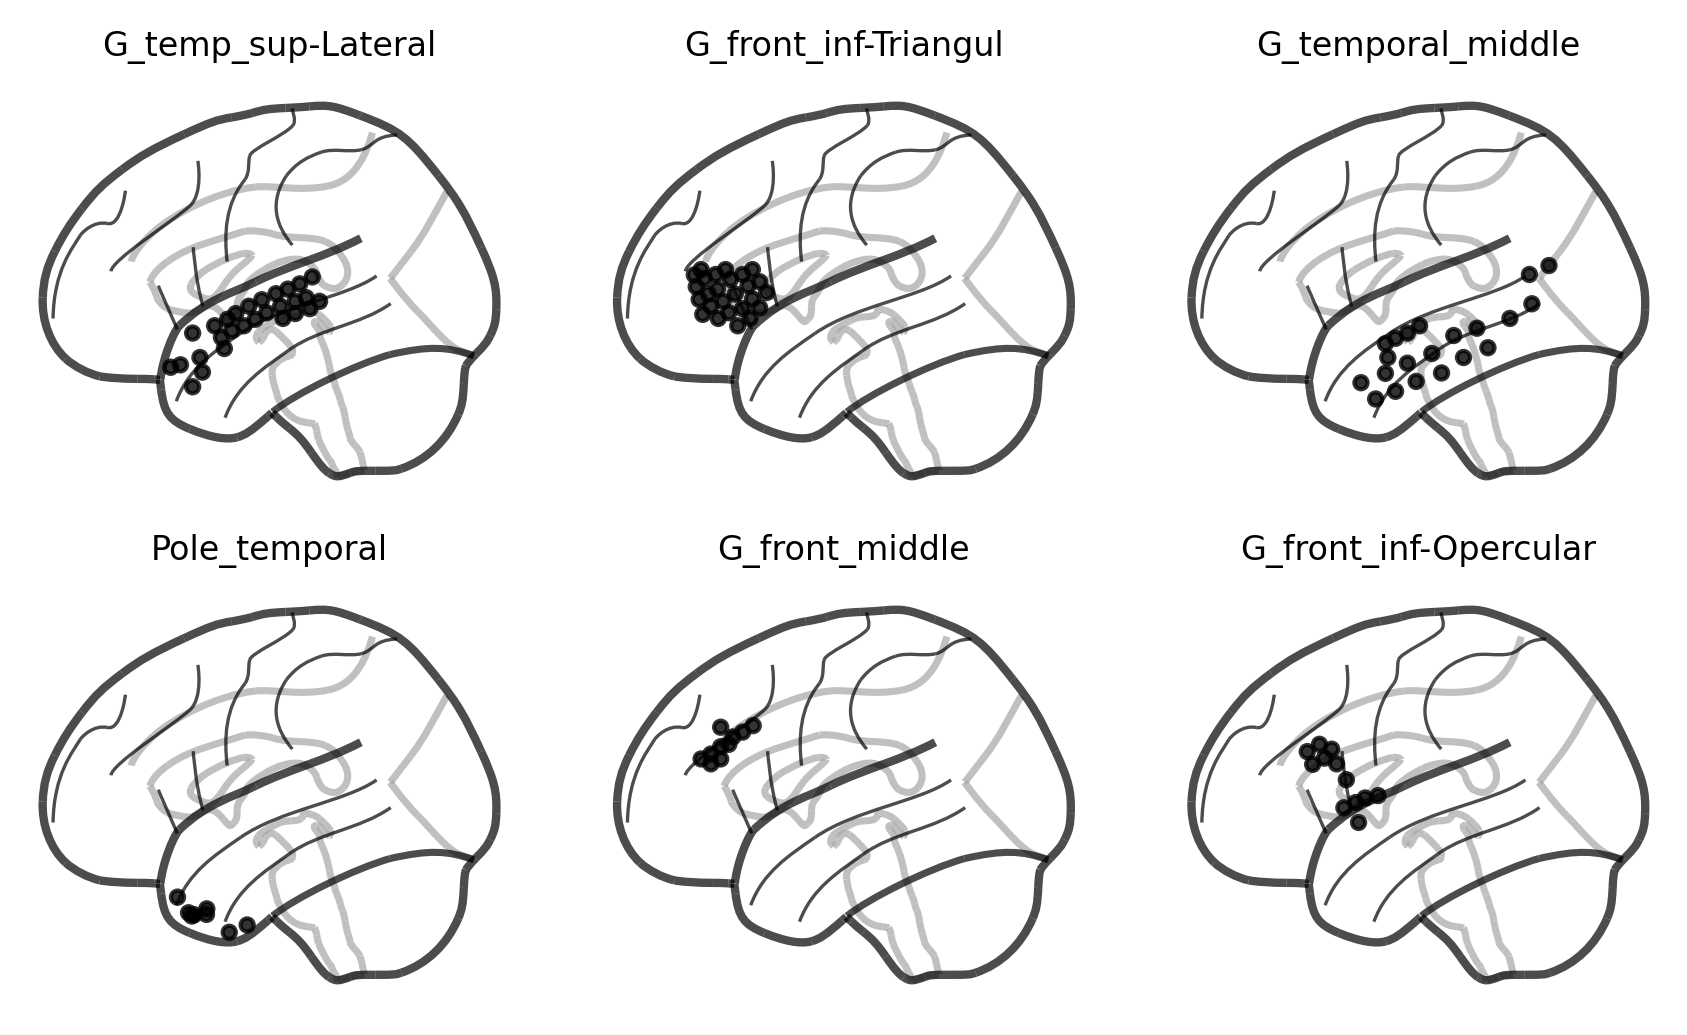

In [39]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, dpi=300, figsize=(7, 4))

for (roi, count), ax in zip(top_rois, axes.ravel()):

    roi_mask = np.array([roi in label for label in elec_labels])
    roi_coords = coords[roi_mask]
    scores = np.ones(len(roi_coords))

    plot_markers(scores, coords[roi_mask],
                node_size=10, display_mode='l',
                alpha=0.8, colorbar=False,
                node_cmap='Grays', node_vmin=0, node_vmax=1,
                figure=fig, axes=ax)

    ax.set_title(roi, fontsize=8)
fig.show()